In [1]:
# Load and combine data

# UNSW-NB15
# https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/

import os
import pandas as pd
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from joblib import dump, load
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# columns=['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 
#          'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 
#          'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 
#          'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 
#          'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 
#          'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 
#          'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 
#          'ct_dst_src_ltm', 'attack_cat', 'Label']

# df = pd.DataFrame(columns=columns)

# for dirname, _, filenames in os.walk('/Users/davidhan/Documents/HKU/Year_4/Final_Year_Project/research/unsw-nb15/raw'):
#     for filename in filenames:
#         path = os.path.join(dirname, filename)
#         print("Loading data from", path)
#         df_temp = pd.read_csv(path, header=None, names=columns)
#         df = df.append(df_temp, ignore_index = True)
        
# df.info(null_counts=True)

In [2]:
df_train = pd.read_csv('/Users/davidhan/Documents/HKU/Year_4/Final_Year_Project/research/unsw-nb15/UNSW_NB15_training-set.csv')
df_test = pd.read_csv('/Users/davidhan/Documents/HKU/Year_4/Final_Year_Project/research/unsw-nb15/UNSW_NB15_testing-set.csv')

In [3]:
df_train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [4]:
df_train.head(20)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
5,6,0.380537,tcp,-,FIN,10,6,534,268,39.417980,254,252,1.011203e+04,4709.134766,2,1,39.928778,52.241000,2223.730342,82.550500,255,3984155503,1796040391,255,0.172934,0.119331,0.053603,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
6,7,0.637109,tcp,-,FIN,10,8,534,354,26.683033,254,252,6.039783e+03,3892.583740,2,1,68.267778,81.137711,4286.828570,119.422719,255,1787309226,1767180493,255,0.143337,0.069136,0.074201,53,44,0,0,43,1,1,1,1,40,0,0,0,1,39,0,Normal,0
7,8,0.521584,tcp,-,FIN,10,8,534,354,32.593026,254,252,7.377527e+03,4754.747070,2,1,55.794000,66.054141,3770.580726,118.962633,255,205985702,316006300,255,0.116615,0.059195,0.057420,53,44,0,0,43,1,3,3,1,40,0,0,0,3,39,0,Normal,0
8,9,0.542905,tcp,-,FIN,10,8,534,354,31.313031,254,252,7.087796e+03,4568.018555,2,1,60.210889,68.109000,4060.625597,106.611547,255,884094874,3410317203,255,0.118584,0.066133,0.052451,53,44,0,0,43,1,3,3,1,40,0,0,0,3,39,0,Normal,0
9,10,0.258687,tcp,-,FIN,10,6,534,268,57.985135,254,252,1.487512e+04,6927.291016,2,1,27.505111,39.106801,1413.686415,57.200395,255,3368447996,584859215,255,0.087934,0.063116,0.024818,53,45,0,0,43,1,3,3,1,40,0,0,0,3,39,0,Normal,0


In [5]:
df_train.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,87671.000000,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,6.712056e+05,4.953000,6.948010,985.976864,88.216296,4.976254e+03,604.353826,116.257339,9.692504e+08,9.688770e+08,115.013625,0.041396,0.021020,0.020375,136.751769,124.173382,0.105982,2.144292e+03,9.306437,1.304179,6.193936,5.383538,4.206255,8.729881,0.014948,0.014948,0.133066,6.955789,9.100758,0.015752,0.680622
std,50616.731112,6.480249,136.887597,110.258271,1.747656e+05,1.436542e+05,1.654010e+05,102.940011,110.506863,1.883574e+08,2.421312e+06,66.005059,52.732999,7242.245841,987.093195,4.496585e+04,4061.043281,127.001024,1.355264e+09,1.354000e+09,126.886530,0.079354,0.043400,0.040506,204.677360,258.317056,0.776911,5.420797e+04,10.704331,0.954406,8.052476,8.047104,5.783585,10.956186,0.126048,0.126048,0.701208,8.321493,10.756952,0.124516,0.466237
min,1.000000,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,43836.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,87671.000000,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,1.447023e+03,0.000000,0.000000,0.279733,0.006000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,131506.000000,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,2.784487e+04,3.000000,2.000000,55.156896,51.053000,2.513295e+03,114.990625,255.000000,1.916651e+09,1.913675e+09,255.000000,0.065481,0.023268,0.038906,100.000000,89.000000,0.000000,0.000000e+00,12.000000,2.000000,7.000000,5.000000,3.000000,12.000000,0.000000,0.000000,0.000000,9.000000,12.000000,0.000000,1.000000
max,175341.000000,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,4803.000000,5484.000000,84371.496000,56716.824000,1.460480e+06,289388.269700,255.000000,4.294959e+09,4.294882e+09,255.000000,2.518893,2.100352,1.520884,1504.000000,1458.000000,172.000000,6.558056e+06,63.000000,6.000000,51.000000,51.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [6]:
df_train['attack_cat'].value_counts()

Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

In [7]:
df_train.drop('id', axis=1, inplace=True)
df_test.drop('id', axis=1, inplace=True)

In [8]:
# Apply scaling to all relevant columns in train and then transform test as well

scaler = StandardScaler()



cols_to_scale = df_train.columns.drop(['proto', 'service', 'state', 'is_ftp_login', 'is_sm_ips_ports', 'attack_cat', 'label'])

df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])

In [9]:
df_train.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000
mean,-3.566066e-18,-1.426426e-17,5.187005e-18,-1.053610e-18,1.410217e-17,-3.241878e-17,-1.607972e-16,-1.141141e-16,1.167076e-17,-6.872782e-17,7.456320e-18,-1.167076e-17,-2.593503e-17,6.807944e-18,1.361589e-17,2.107221e-17,2.334152e-17,8.428884e-17,-4.927655e-17,1.426426e-16,6.872782e-17,-1.115206e-16,6.743107e-17,-1.491264e-17,-1.815452e-17,-2.139640e-17,9.117783e-18,4.408955e-17,2.593503e-17,1.115206e-16,9.336610e-17,3.630904e-17,5.187005e-17,0.014948,-6.483757e-18,-5.187005e-18,3.630904e-17,-8.299209e-17,0.015752,0.680622
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.126048,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.124516,0.466237
min,-2.097747e-01,-1.409822e-01,-1.720474e-01,-5.044967e-02,-1.039229e-01,-5.768192e-01,-1.744196e+00,-7.204059e-01,-3.899726e-01,-2.772081e-01,-7.503992e-02,-1.317587e-01,-1.361428e-01,-8.937003e-02,-1.106677e-01,-1.488178e-01,-9.154073e-01,-7.151765e-01,-7.155688e-01,-9.064315e-01,-5.216596e-01,-4.843460e-01,-5.030137e-01,-5.313342e-01,-4.807028e-01,-1.364151e-01,-3.955687e-02,-7.759906e-01,-1.366486e+00,-6.450129e-01,-5.447364e-01,-5.543732e-01,-7.055286e-01,0.000000,-1.185902e-01,-1.897681e-01,-7.157137e-01,-7.530740e-01,0.000000,0.000000
25%,-2.097735e-01,-1.336769e-01,-1.720474e-01,-4.995758e-02,-1.039229e-01,-5.766210e-01,-1.141901e+00,-7.204059e-01,-3.899033e-01,-2.772081e-01,-7.503992e-02,-1.317587e-01,-1.361417e-01,-8.937003e-02,-1.106677e-01,-1.488178e-01,-9.154073e-01,-7.151765e-01,-7.155688e-01,-9.064315e-01,-5.216596e-01,-4.843460e-01,-5.030137e-01,-3.896474e-01,-4.807028e-01,-1.364151e-01,-3.955687e-02,-6.825702e-01,-3.187109e-01,-6.450129e-01,-5.447364e-01,-5.543732e-01,-7.055286e-01,0.000000,-1.185902e-01,-1.897681e-01,-5.955426e-01,-6.601106e-01,0.000000,0.000000
50%,-2.095306e-01,-1.336769e-01,-1.539081e-01,-4.814944e-02,-1.027813e-01,-5.573162e-01,7.232680e-01,-4.579780e-01,-3.853023e-01,-2.766105e-01,-7.503992e-02,-1.317587e-01,-1.361042e-01,-8.936395e-02,-1.106677e-01,-1.488178e-01,-9.154073e-01,-7.151765e-01,-7.155688e-01,-9.064315e-01,-5.216596e-01,-4.843460e-01,-5.030137e-01,-3.114753e-01,-3.103690e-01,-1.364151e-01,-3.955687e-02,-4.023091e-01,-3.187109e-01,-5.208272e-01,-5.447364e-01,-5.543732e-01,-5.229828e-01,0.000000,-1.185902e-01,-1.897681e-01,-4.753715e-01,-4.741838e-01,0.000000,1.000000
75%,-1.066813e-01,-6.062410e-02,-8.135096e-02,-4.249614e-02,-9.625167e-02,1.789221e-01,7.232680e-01,1.560002e+00,8.194472e-02,-2.657082e-01,-2.958873e-02,-9.383164e-02,-1.285268e-01,-3.764934e-02,-5.477415e-02,-1.205022e-01,1.092456e+00,6.990545e-01,6.977848e-01,1.103244e+00,3.035188e-01,5.178726e-02,4.574803e-01,-1.795600e-01,-1.361640e-01,-1.364151e-01,-3.955687e-02,2.516337e-01,7.290641e-01,1.001016e-01,-4.766180e-02,-2.085659e-

In [10]:
# Why are there ftp_logins that are not binary?

df_train.is_ftp_login.value_counts()

0    172774
1      2545
4        16
2         6
Name: is_ftp_login, dtype: int64

In [12]:
# Categorize protocol, service types, and state:

def value_checker(row, col_name, value):
    if row[col_name] == value:
        return 1
    else:
        return 0

In [13]:
print(df_train['proto'].value_counts())
print(df_train['service'].value_counts())
print(df_train['state'].value_counts())

tcp            79946
udp            63283
unas           12084
arp             2859
ospf            2595
sctp            1150
any              300
gre              225
pim              201
mobile           201
swipe            201
sun-nd           201
ipv6             201
rsvp             200
sep              193
ib               101
xtp              100
ipcv             100
zero             100
ippc             100
sprite-rpc       100
ipv6-no          100
fire             100
fc               100
visa             100
iso-ip           100
ax.25            100
a/n              100
ptp              100
aris             100
l2tp             100
ipv6-frag        100
sccopmce         100
wsn              100
crudp            100
ipip             100
vines            100
isis             100
idpr-cmtp        100
pgm              100
nsfnet-igp       100
ipcomp           100
kryptolan        100
ttp              100
ddx              100
larp             100
iplt             100
wb-mon       

In [14]:
# Pseudo dummy variables for protocols, services and states

protocols = ['tcp', 'udp', 'unas', 'arp', 'ospf', 'sctp']
services = ['dns', 'http', 'smtp', 'ftp-data', 'ftp', 'ssh', 'pop3']
states = ['INT', 'FIN', 'CON', 'REQ']
 
for protocol in protocols:
    col_name = 'protocol_' + protocol
    df_test[col_name] = df_test.apply(lambda row: value_checker(row, 'proto', protocol), axis=1)
    df_train[col_name] = df_train.apply(lambda row: value_checker(row, 'proto', protocol), axis=1)
    print('added', col_name)

for service in services:
    col_name = 'service_' + service
    df_test[col_name] = df_test.apply(lambda row: value_checker(row, 'service', service), axis=1)
    df_train[col_name] = df_train.apply(lambda row: value_checker(row, 'service', service), axis=1)
    print('added', col_name)

for state in states:
    col_name = 'state_' + state
    df_test[col_name] = df_test.apply(lambda row: value_checker(row, 'state', state), axis=1)
    df_train[col_name] = df_train.apply(lambda row: value_checker(row, 'state', state), axis=1)
    print('added', col_name)


df_train.drop(['proto', 'service', 'state'],axis=1, inplace=True)
df_test.drop(['proto', 'service', 'state'],axis=1, inplace=True)

added protocol_tcp
added protocol_udp
added protocol_unas
added protocol_arp
added protocol_ospf
added protocol_sctp
added service_dns
added service_http
added service_smtp
added service_ftp-data
added service_ftp
added service_ssh
added service_pop3
added state_INT
added state_FIN
added state_CON
added state_REQ


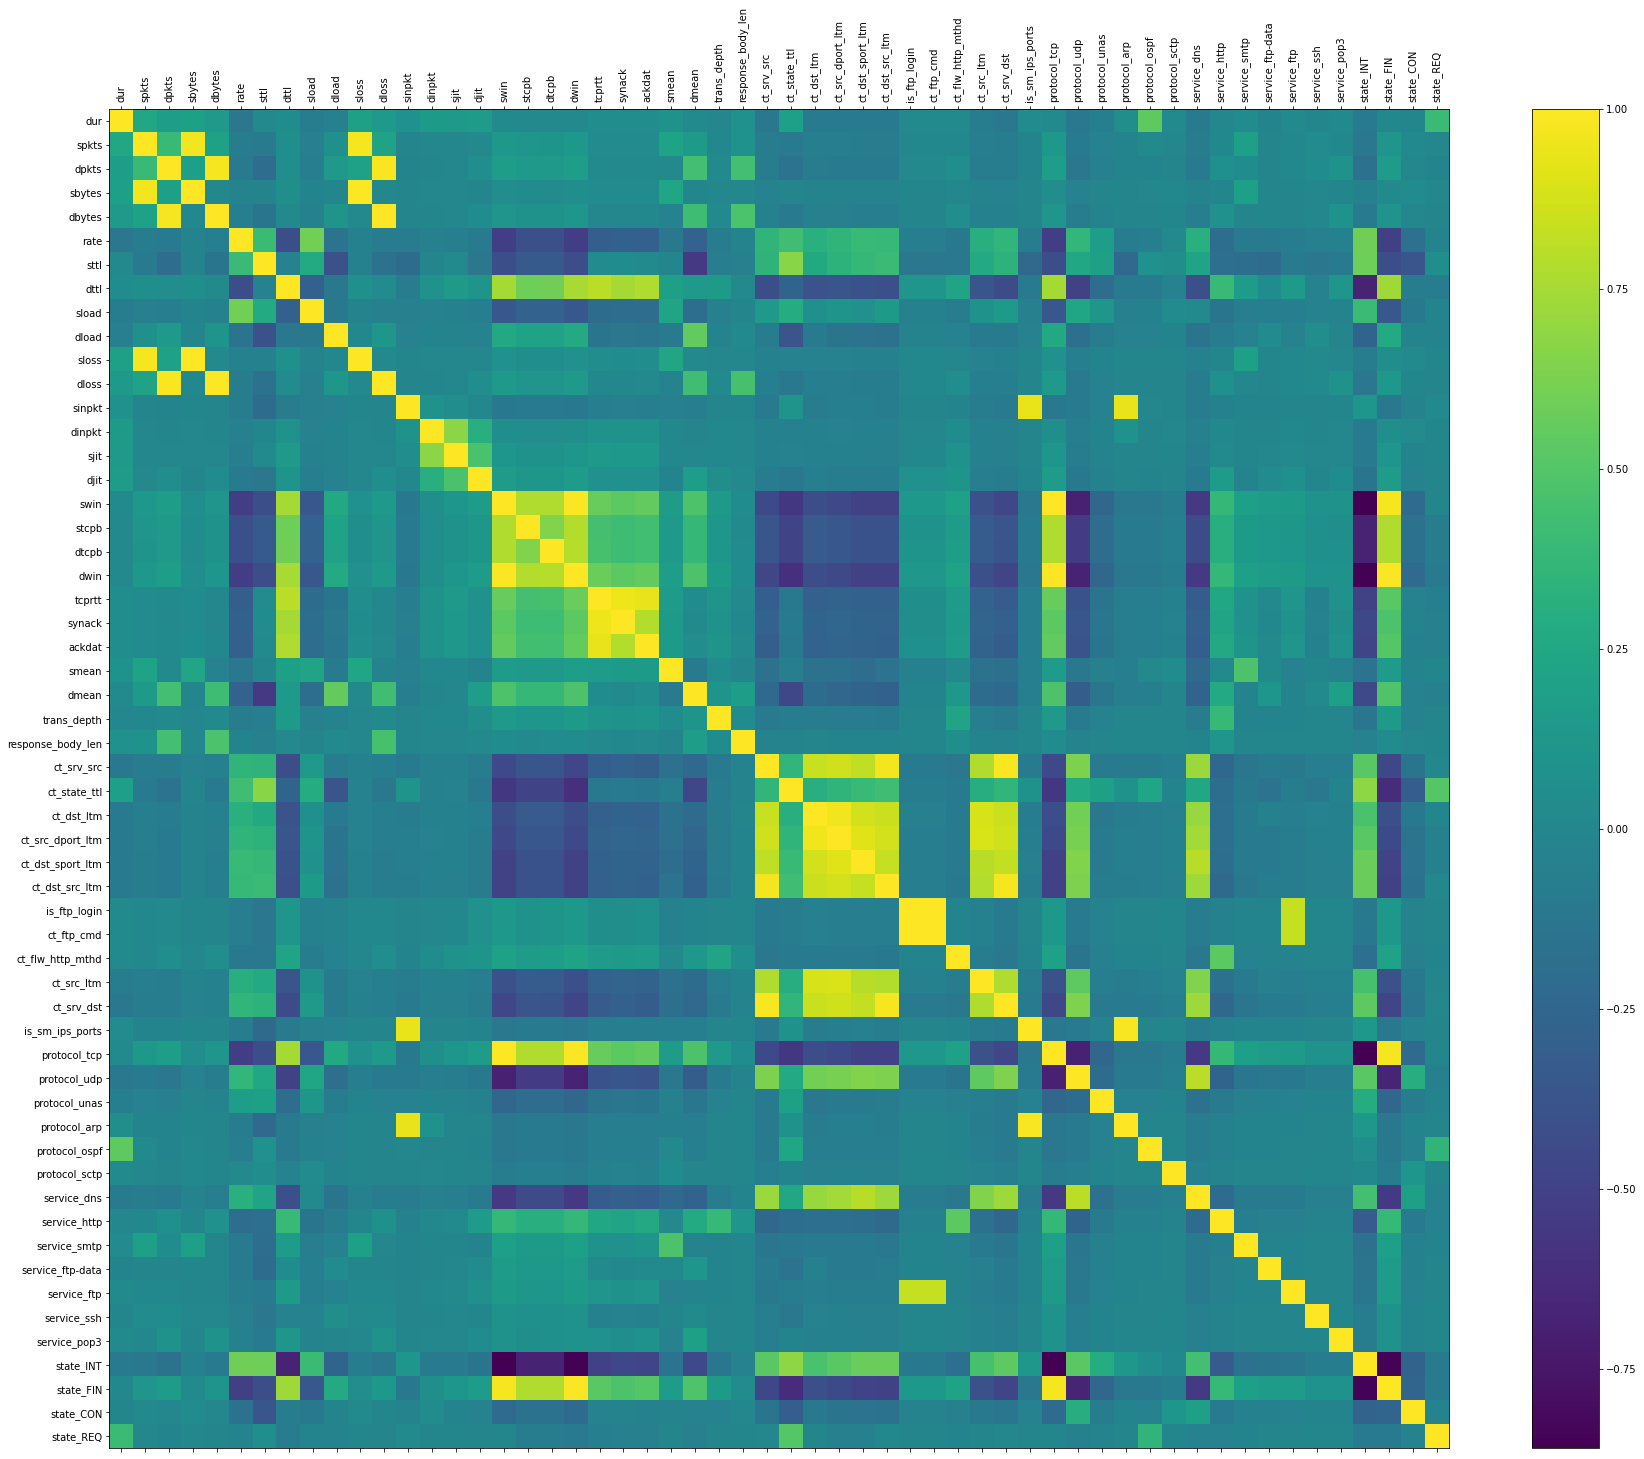

In [15]:
df_corr = df_train.drop(['attack_cat', 'label'],axis=1)

f = plt.figure(figsize=(30, 24))
plt.matshow(df_corr.corr(), fignum=f.number)
plt.xticks(range(df_corr.shape[1]), df_corr.columns, fontsize=10, rotation=90)
plt.yticks(range(df_corr.shape[1]), df_corr.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

In [16]:
# Determine columns in extended matrix with correlation >.95

corr_matrix = df_corr.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop_95 = [column for column in upper.columns if any(upper[column] > 0.95)]

to_drop_95

['sbytes',
 'dbytes',
 'sloss',
 'dloss',
 'dwin',
 'ct_src_dport_ltm',
 'ct_dst_src_ltm',
 'ct_ftp_cmd',
 'ct_srv_dst',
 'protocol_tcp',
 'protocol_arp',
 'state_FIN']

In [17]:
# Function to group attacks into a larger subset

def attack_type_to_int(row):
    if row['attack_cat'] == 'Normal':
        return 0
    elif row['attack_cat'] == 'Generic':
        return 1
    elif row['attack_cat'] == 'Exploits': 
        return 2
    elif row['attack_cat'] == 'Fuzzers':
        return 3
    elif row['attack_cat'] == 'DoS':
        return 4
    elif row['attack_cat'] == 'Reconnaissance': 
        return 5
    elif row['attack_cat'] == 'Analysis':
        return 6
    elif row['attack_cat'] == 'Backdoor': 
        return 7
    elif row['attack_cat'] == 'Shellcode':
        return 8
    elif row['attack_cat'] == 'Worms':
        return 9
    else:
        return 10

In [18]:
df_train['attack_type'] = df_train.apply(lambda row: attack_type_to_int(row), axis=1)
df_train = df_train.drop(['attack_cat', 'label'], axis=1)

df_test['attack_type'] = df_test.apply(lambda row: attack_type_to_int(row), axis=1)
df_test = df_test.drop(['attack_cat', 'label'], axis=1)

df_train['attack_type'].value_counts()

0    56000
1    40000
2    33393
3    18184
4    12264
5    10491
6     2000
7     1746
8     1133
9      130
Name: attack_type, dtype: int64

In [19]:
# Maybe downsample for visualization?

df_visualization = df_train.copy(deep=True)

Explained variation per principal component: [0.27693098 0.09966024 0.09268086]


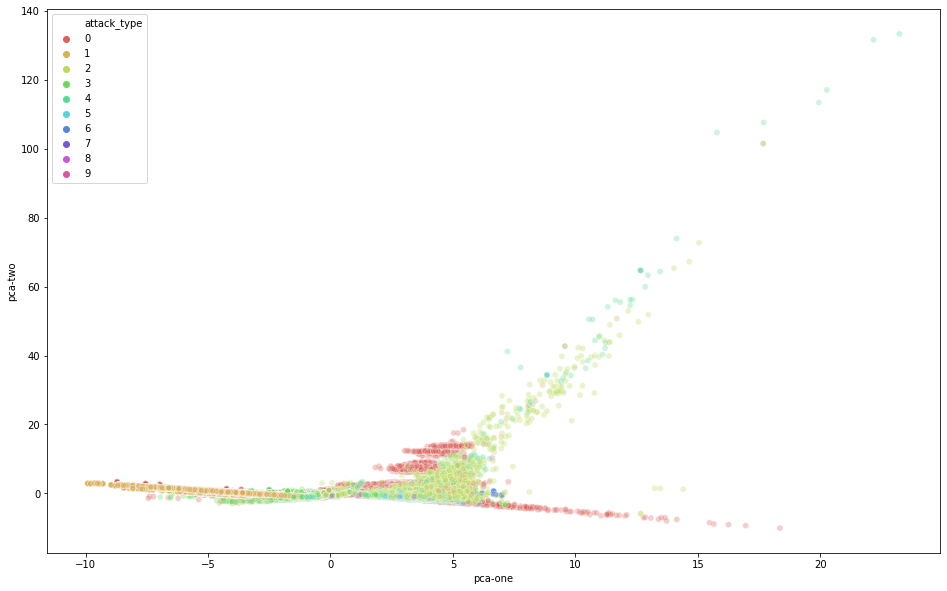

In [20]:
# PCA to see how principal component accounts for variance

df_visualization_features = df_visualization.drop('attack_type', axis=1)

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_visualization_features.values)
df_visualization['pca-one'] = pca_result[:,0]
df_visualization['pca-two'] = pca_result[:,1] 
df_visualization['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# Plot 2D PCA

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="attack_type",
    palette=sns.color_palette("hls", 10),
    data=df_visualization,
    legend="full",
    alpha=0.3
)

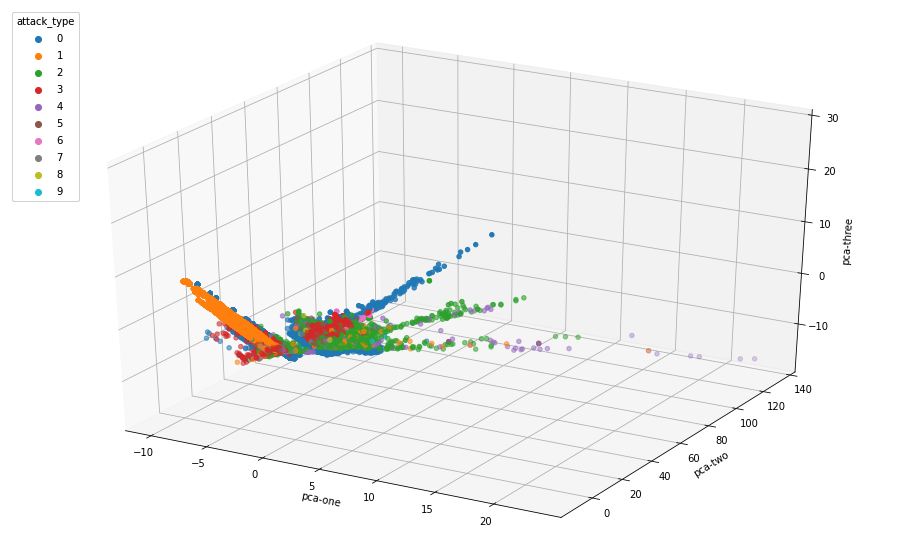

In [21]:
# Plot 3D PCA

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
graph = ax.scatter(
    xs=df_visualization["pca-one"], 
    ys=df_visualization["pca-two"], 
    zs=df_visualization["pca-three"], 
    c=df_visualization["attack_type"], 
    cmap='tab10',
)
legend1 = ax.legend(*graph.legend_elements(),
                    loc="upper left", title="attack_type")
ax.add_artist(legend1)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()



In [22]:
# Drop pca axes after use

df_visualization = df_visualization.drop(columns=['pca-one', 'pca-two', 'pca-three'], axis=1)

In [23]:
# TOO MANY DATA POINTS: DON'T GO ABOVE 100K

# # Run TSNE on data

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(df_visualization_features)

# df_visualization['tsne-2d-one'] = tsne_results[:,0]
# df_visualization['tsne-2d-two'] = tsne_results[:,1]
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="attack_type",
#     palette=sns.color_palette("hls", 10),
#     data=df_visualization,
#     legend="full",
#     alpha=0.3
# )

In [24]:
df_vis = df_train.copy(deep=True)

df_0 = df_vis[df_vis.attack_type==0]
df_1 = df_vis[df_vis.attack_type==1]
df_2 = df_vis[df_vis.attack_type==2]
df_3 = df_vis[df_vis.attack_type==3]
df_4 = df_vis[df_vis.attack_type==4]
df_5 = df_vis[df_vis.attack_type==5]
df_minority = df_vis[df_vis.attack_type>5]
 
df_0 = resample(df_0, replace=False, n_samples=20000, random_state=17) 
df_1 = resample(df_1, replace=False, n_samples=10000, random_state=17) 
df_2 = resample(df_2, replace=False, n_samples=10000, random_state=17) 
df_3 = resample(df_3, replace=False, n_samples=7500, random_state=17) 
df_4 = resample(df_4, replace=False, n_samples=5000, random_state=17) 
df_5 = resample(df_5, replace=False, n_samples=5000, random_state=17) 
 
df_visualization = pd.concat([df_0, 
                            df_1, 
                            df_2, 
                            df_3, 
                            df_4,
                            df_5,
                            df_minority])
 
df_visualization['attack_type'].value_counts()

5    5000
4    5000
3    5000
2    5000
1    5000
0    5000
6    2000
7    1746
8    1133
9     130
Name: attack_type, dtype: int64

Explained variation per principal component: [0.26399299 0.10647448 0.0883807 ]


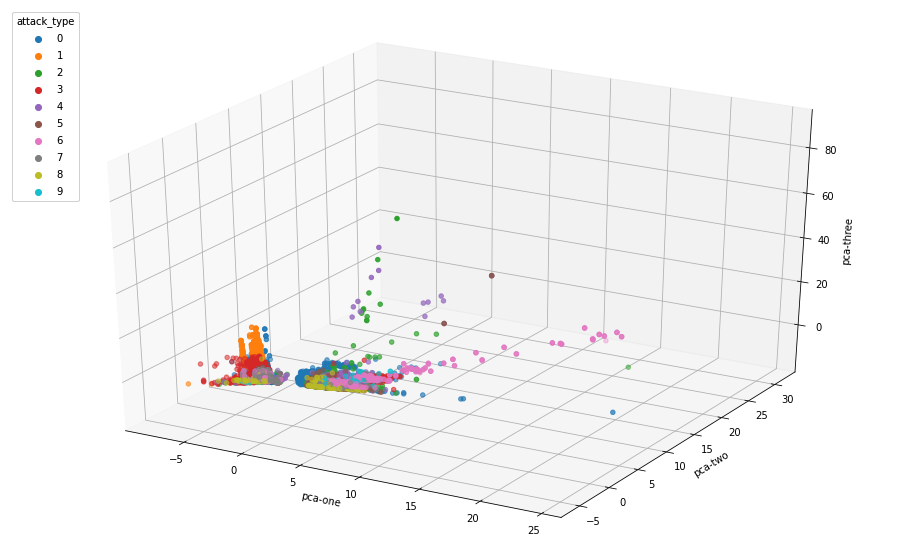

In [25]:
# Plot 3D PCA

df_visualization_features = df_visualization.drop('attack_type', axis=1)

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_visualization_features.values)
df_visualization['pca-one'] = pca_result[:,0]
df_visualization['pca-two'] = pca_result[:,1] 
df_visualization['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


ax = plt.figure(figsize=(16,10)).gca(projection='3d')
graph = ax.scatter(
    xs=df_visualization["pca-one"], 
    ys=df_visualization["pca-two"], 
    zs=df_visualization["pca-three"], 
    c=df_visualization["attack_type"], 
    cmap='tab10',
)
legend1 = ax.legend(*graph.legend_elements(),
                    loc="upper left", title="attack_type")
ax.add_artist(legend1)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 35009 samples in 1.321s...
[t-SNE] Computed neighbors for 35009 samples in 24.567s...
[t-SNE] Computed conditional probabilities for sample 1000 / 35009
[t-SNE] Computed conditional probabilities for sample 2000 / 35009
[t-SNE] Computed conditional probabilities for sample 3000 / 35009
[t-SNE] Computed conditional probabilities for sample 4000 / 35009
[t-SNE] Computed conditional probabilities for sample 5000 / 35009
[t-SNE] Computed conditional probabilities for sample 6000 / 35009
[t-SNE] Computed conditional probabilities for sample 7000 / 35009
[t-SNE] Computed conditional probabilities for sample 8000 / 35009
[t-SNE] Computed conditional probabilities for sample 9000 / 35009
[t-SNE] Computed conditional probabilities for sample 10000 / 35009
[t-SNE] Computed conditional probabilities for sample 11000 / 35009
[t-SNE] Computed conditional probabilities for sample 12000 / 35009
[t-SNE] Computed conditional probabilities for s

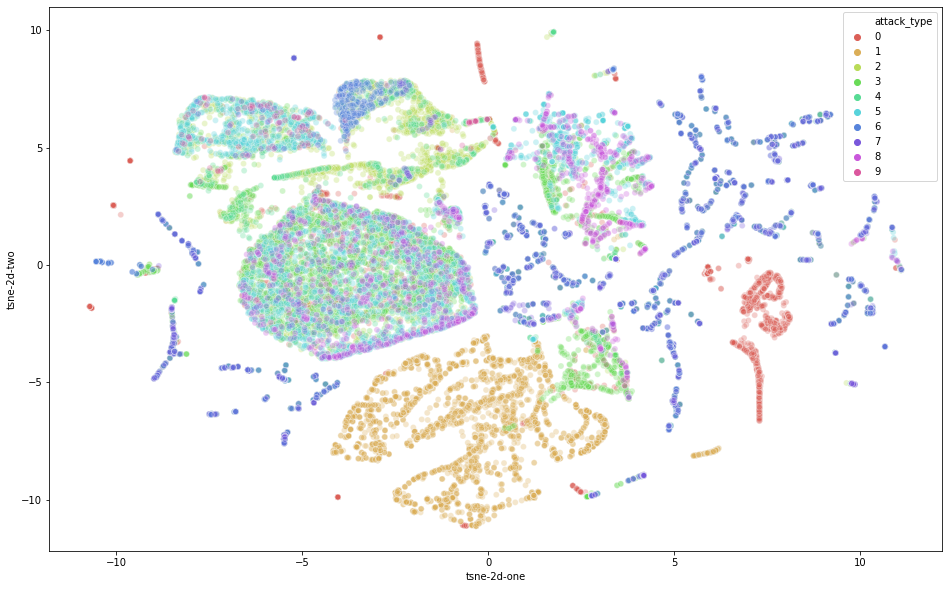

In [26]:
# Run TSNE on data

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_visualization_features)

df_visualization['tsne-2d-one'] = tsne_results[:,0]
df_visualization['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="attack_type",
    palette=sns.color_palette("hls", 10),
    data=df_visualization,
    legend="full",
    alpha=0.3
)

In [27]:
# Split dfs into features and labels
y_train = df_train['attack_type']
X_train = df_train.drop('attack_type', axis=1)
y_test = df_test['attack_type']
X_test = df_test.drop('attack_type', axis=1)

# Create train and test with correlated features removed
X_train_95 = X_train.drop(to_drop_95, axis=1)
X_test_95 = X_test.drop(to_drop_95, axis=1)

In [28]:
# Combine minority classes for better class balance

y_train = y_train.apply(lambda x: 1 if x > 0 else 0)
y_test = y_test.apply(lambda x: 1 if x > 0 else 0)

print(y_train.value_counts())
print(y_test.value_counts())

1    119341
0     56000
Name: attack_type, dtype: int64
1    45332
0    37000
Name: attack_type, dtype: int64


In [29]:
def fit_and_score_ensemble_classifier(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    print('Accuracy:', accuracy_score(y_test, y_pred), '\n')
    print(precision_recall_fscore_support(y_test, y_pred), '\n')
    print('F1_score:', f1_score(y_test, y_pred), '\n')
    print(classification_report(y_test, y_pred), '\n')
    print(confusion_matrix(y_test, y_pred), '\n')
    print(confusion_matrix(y_test, y_pred, normalize='true'), '\n')

    
def plot_feature_importances(model, labels, color):
    values = model.feature_importances_
    index = np.arange(len(labels))
    fig = plt.figure(figsize=(16, 10))
    plt.bar(index, values, color=color)
    plt.xlabel('Feature', fontsize=10)
    plt.ylabel('Importance', fontsize=10)
    plt.xticks(index, labels, fontsize=10, rotation=90)
    plt.show()

def export_model(model, filename):
    # Dump to a retrievable file: model = load('filename.joblib') 
    dump(model, filename + '.joblib') 
    # save to Onnx file type
    initial_type = [('float_input', FloatTensorType([None, 70]))]
    onx = convert_sklearn(rf_model, initial_types=initial_type)
    with open(filename + '.onnx', 'wb') as f:
        f.write(onx.SerializeToString())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy: 0.8722610892484088 

(array([0.97694774, 0.8189998 ]), array([0.73305405, 0.98588194]), array([0.83760789, 0.89472578]), array([37000, 45332])) 

F1_score: 0.8947257785207355 

              precision    recall  f1-score   support

           0       0.98      0.73      0.84     37000
           1       0.82      0.99      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.90      0.86      0.87     82332
weighted avg       0.89      0.87      0.87     82332
 

[[27123  9877]
 [  640 44692]] 

[[0.73305405 0.26694595]
 [0.01411806 0.98588194]] 



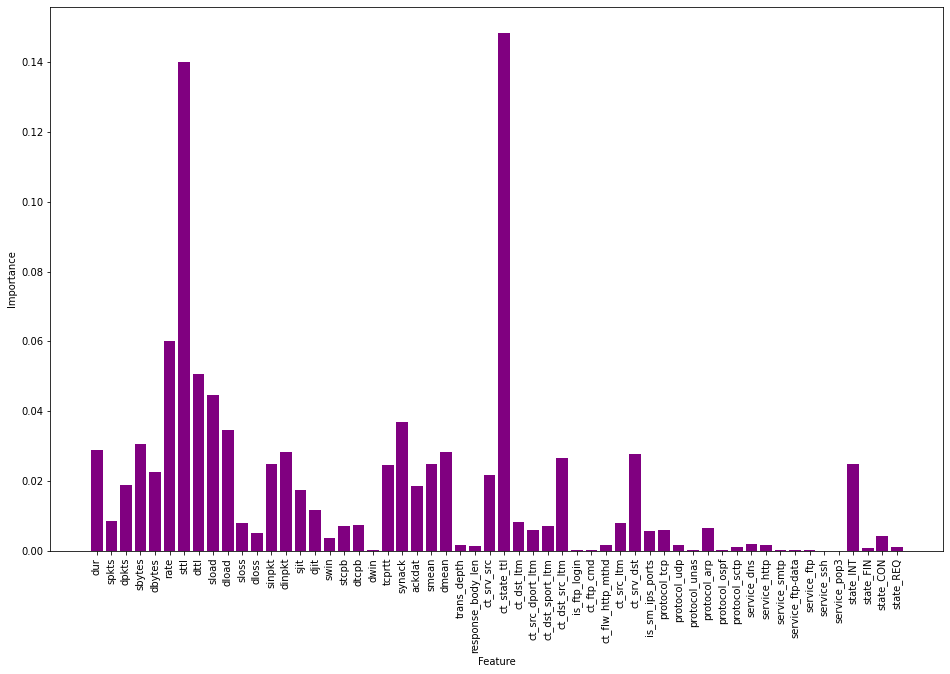

In [30]:
# Random Forest on all columns

rf_model = RandomForestClassifier(n_estimators=100, 
                            bootstrap = True,
                            max_features = 'sqrt',
                            verbose=True,
                            random_state=25)

fit_and_score_ensemble_classifier(rf_model, X_train, y_train, X_test, y_test)
plot_feature_importances(rf_model, X_train.columns, 'purple')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy: 0.858171792255745 

(array([0.95318372, 0.80936885]), array([0.71975676, 0.97114621]), array([0.8201851, 0.882908 ]), array([37000, 45332])) 

F1_score: 0.8829079969917273 

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     37000
           1       0.81      0.97      0.88     45332

    accuracy                           0.86     82332
   macro avg       0.88      0.85      0.85     82332
weighted avg       0.87      0.86      0.85     82332
 

[[26631 10369]
 [ 1308 44024]] 

[[0.71975676 0.28024324]
 [0.02885379 0.97114621]] 



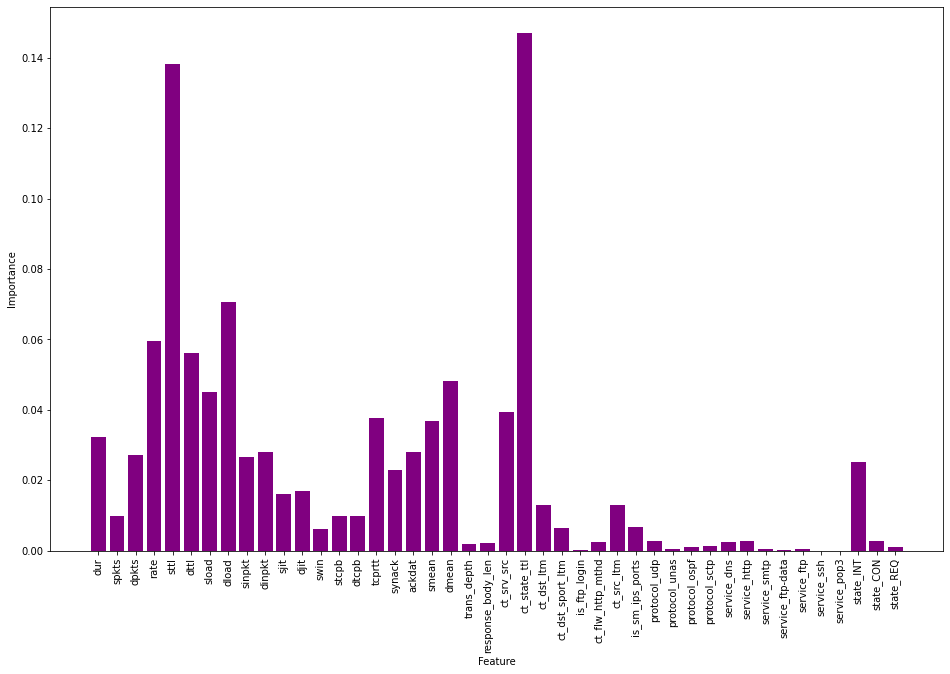

In [31]:
# Random Forest Classifier on reduced_95 

rf_model_95 = RandomForestClassifier(n_estimators=100, 
                            bootstrap = True,
                            max_features = 'sqrt',
                            verbose=True,
                            random_state=25)

fit_and_score_ensemble_classifier(rf_model_95, X_train_95, y_train, X_test_95, y_test)
plot_feature_importances(rf_model_95, X_train_95.columns, 'purple')

Accuracy: 0.8759656026818248 

(array([0.97409033, 0.82470414]), array([0.74378378, 0.98385247]), array([0.84349905, 0.89727598]), array([37000, 45332])) 

F1_score: 0.8972759827787391 

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     37000
           1       0.82      0.98      0.90     45332

    accuracy                           0.88     82332
   macro avg       0.90      0.86      0.87     82332
weighted avg       0.89      0.88      0.87     82332
 

[[27520  9480]
 [  732 44600]] 

[[0.74378378 0.25621622]
 [0.01614753 0.98385247]] 



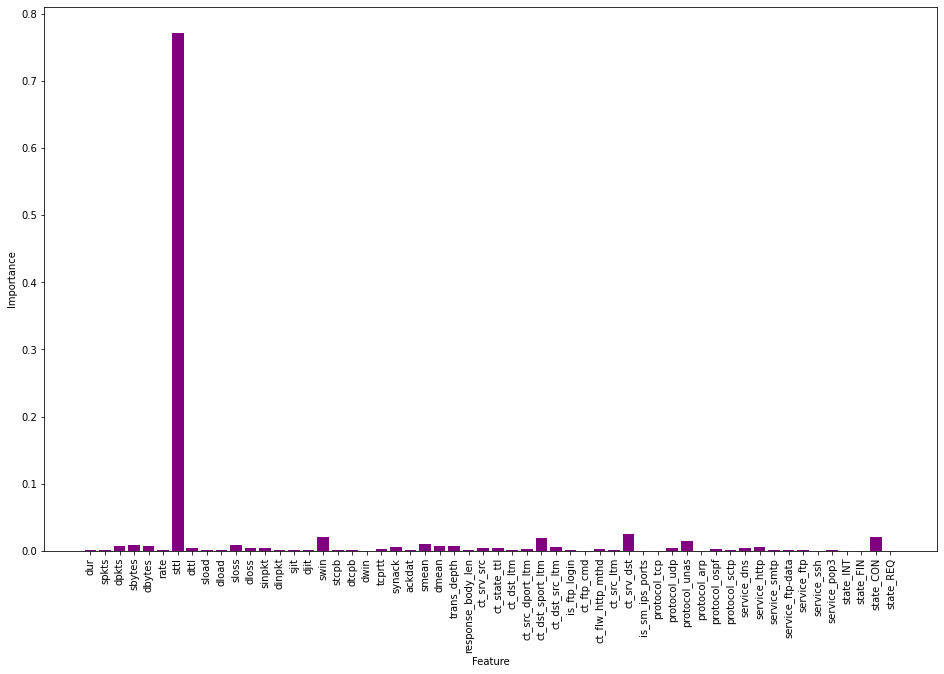

In [32]:
# XGB on all columns

xgb_model = XGBClassifier(verbosity=1, importance_type='gain', random_state=25)

fit_and_score_ensemble_classifier(xgb_model, X_train, y_train, X_test, y_test)
plot_feature_importances(xgb_model, X_train.columns, 'purple')

Accuracy: 0.8640504299664772 

(array([0.95219905, 0.81729464]), array([0.73435135, 0.96991088]), array([0.82920577, 0.88708652]), array([37000, 45332])) 

F1_score: 0.8870865236207367 

              precision    recall  f1-score   support

           0       0.95      0.73      0.83     37000
           1       0.82      0.97      0.89     45332

    accuracy                           0.86     82332
   macro avg       0.88      0.85      0.86     82332
weighted avg       0.88      0.86      0.86     82332
 

[[27171  9829]
 [ 1364 43968]] 

[[0.73435135 0.26564865]
 [0.03008912 0.96991088]] 



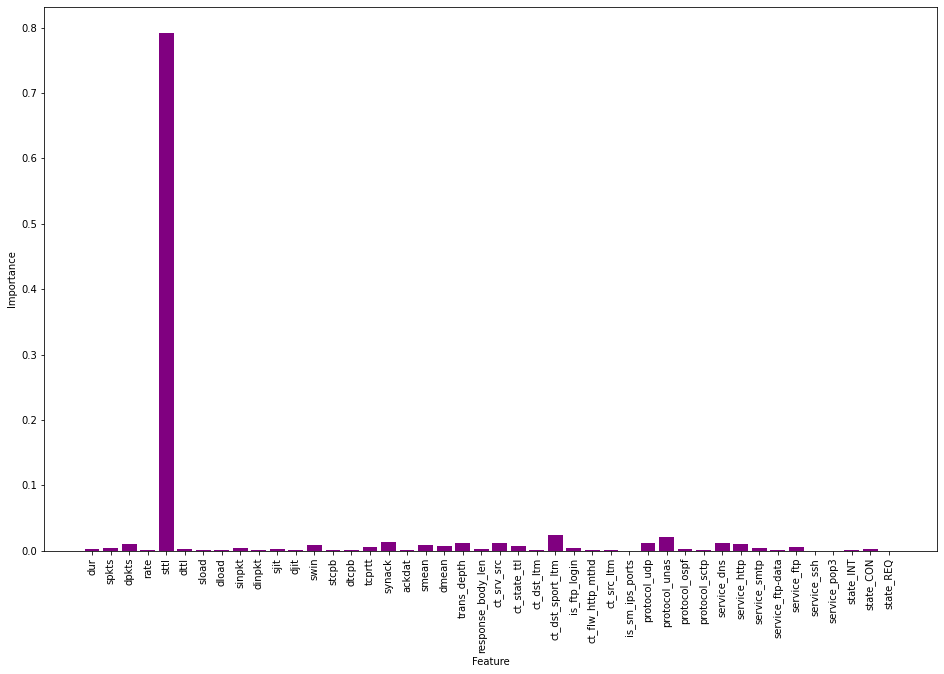

In [33]:
# XGB on 95 reduced

xgb_model_95 = XGBClassifier(verbosity=1, importance_type='gain', random_state=25)

fit_and_score_ensemble_classifier(xgb_model_95, X_train_95, y_train, X_test_95, y_test)
plot_feature_importances(xgb_model_95, X_train_95.columns, 'purple')

Accuracy: 0.8746659864937084 

(array([0.9769404 , 0.82204154]), array([0.73854054, 0.98577164]), array([0.84117529, 0.89649223]), array([37000, 45332])) 

F1_score: 0.8964922311496294 

              precision    recall  f1-score   support

           0       0.98      0.74      0.84     37000
           1       0.82      0.99      0.90     45332

    accuracy                           0.87     82332
   macro avg       0.90      0.86      0.87     82332
weighted avg       0.89      0.87      0.87     82332
 

[[27326  9674]
 [  645 44687]] 

[[0.73854054 0.26145946]
 [0.01422836 0.98577164]] 



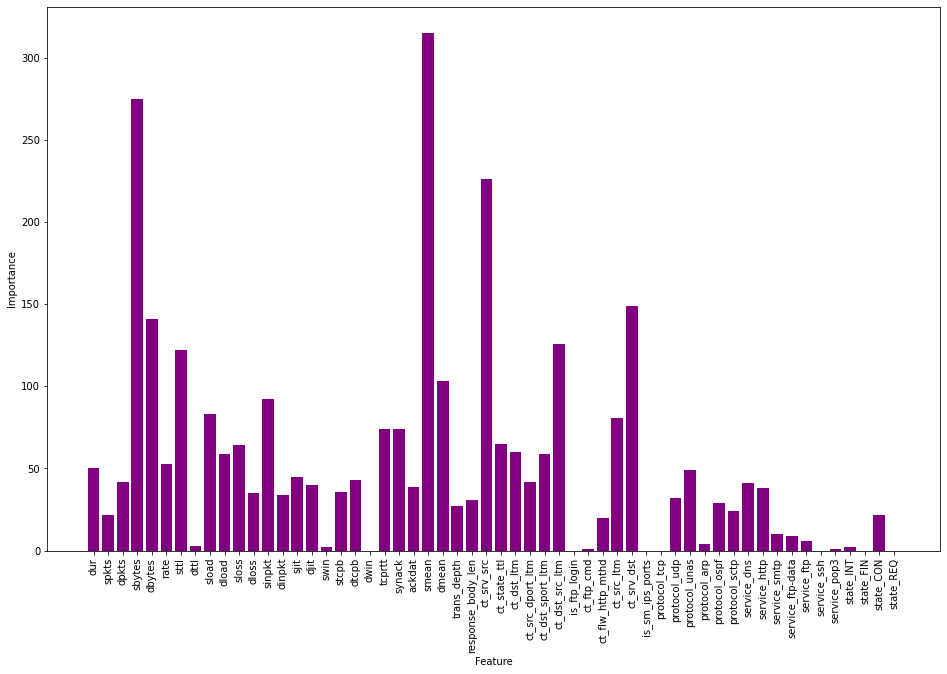

In [34]:
# LGBM on all columns

lgbm_model = LGBMClassifier(silent=False, random_state=25)

fit_and_score_ensemble_classifier(lgbm_model, X_train, y_train, X_test, y_test)
plot_feature_importances(lgbm_model, X_train.columns, 'purple')

Accuracy: 0.8649006461643104 

(array([0.9545726 , 0.81752028]), array([0.73432432, 0.9714771 ]), array([0.83008722, 0.88787411]), array([37000, 45332])) 

F1_score: 0.887874114172236 

              precision    recall  f1-score   support

           0       0.95      0.73      0.83     37000
           1       0.82      0.97      0.89     45332

    accuracy                           0.86     82332
   macro avg       0.89      0.85      0.86     82332
weighted avg       0.88      0.86      0.86     82332
 

[[27170  9830]
 [ 1293 44039]] 

[[0.73432432 0.26567568]
 [0.0285229  0.9714771 ]] 



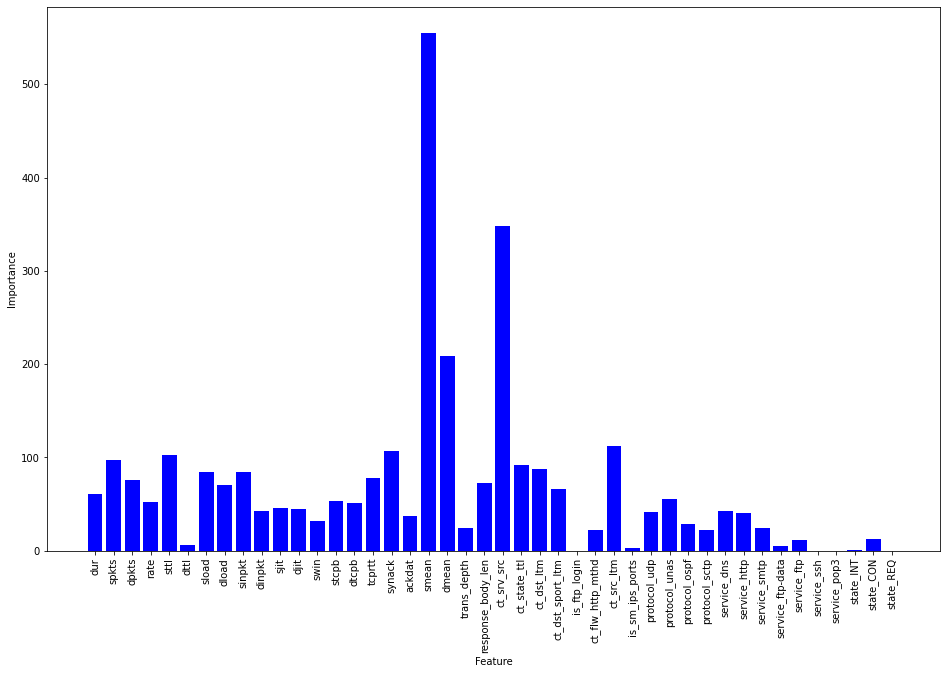

In [35]:
# LGBM on 95 reduced

lgbm_model_95 = LGBMClassifier(silent=False, random_state=1001)

fit_and_score_ensemble_classifier(lgbm_model_95, X_train_95, y_train, X_test_95, y_test)
plot_feature_importances(lgbm_model_95, X_train_95.columns, 'purple')